In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
def cliffsDelta(lst1, lst2, **dull):
    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d #, size                  # Закоментировал возвращение дискретного значения размера эффекта,
                                      # чтобы без проблем использовать bootstrap 

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two
    
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    N = 1,
    concat = True,
    plot_flag = False,
    colname = ''
):
    if (concat):
        boot_len_1 = len(data_column_1)
        boot_len_2 = len(data_column_2)
        data_for_sample_1 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        data_for_sample_2 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        const = statistic(data_column_1) - statistic(data_column_2)
    else:
        boot_len_1 = max([len(data_column_1), len(data_column_2)])
        boot_len_2 = max([len(data_column_1), len(data_column_2)])
        data_for_sample_1 = data_column_1
        data_for_sample_2 = data_column_2
        const = 0
        
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_for_sample_1.sample(
            boot_len_1, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_for_sample_2.sample(
            boot_len_2,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    quants.columns = [str(statistic.__name__)]
    
    if (concat):
        p_value = norm.cdf(x = -np.abs(const), loc = np.mean(boot_data), scale = np.std(boot_data)) * 2
    else:
        p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p_1, p_2) * 2
    
    if p_value > 1:
        p_value = 1
        
    # Визуализация
    
    if(plot_flag):
        sns.displot(x = pd_boot_data[0], kind = "kde", fill = True)
        plt.axvline(const, linestyle='-', color='black')
        plt.axvline(quants.values[0], linestyle='--', color='green')
        plt.axvline(quants.values[1], linestyle='--', color='green')
        plt.xlabel('Разность ' + str(statistic.__name__) + ' двух групп')

        plt.title("Histogram of " + colname)
        plt.savefig(f'plots/bootstrap/{colname}', bbox_inches='tight')
        plt.show()
        

    if (const >= quants.iloc[:, 0].iloc[0]) & (const <= quants.iloc[:, 0].iloc[1]):
        result = False
    else:
        if (p_value >= 0.01 / N):
            result = False
        else:
            result = True
            
    observed_difference = statistic(data_column_1) - statistic(data_column_2)
       
    return {"result": result,
            "observed_difference": observed_difference,
            "quants": quants,
            "p_value": p_value}

In [3]:
df = pd.read_csv('df_total.csv', index_col=0)
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

for col in tqdm(cols):
    df[col] = (df[col] - df[col].quantile(0.01)) / (df[col].quantile(0.99) - df[col].quantile(0.001))
    
df['Категория'] = df['fraud'].replace({True: 'Мошенник', False: 'Не мошенник'})
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

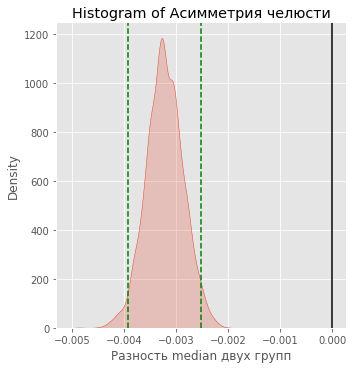

p_value:  1.4318491429256552e-19 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

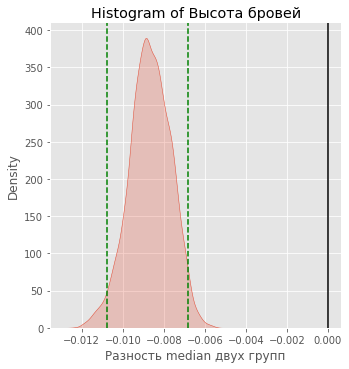

p_value:  1.1530121263518339e-17 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

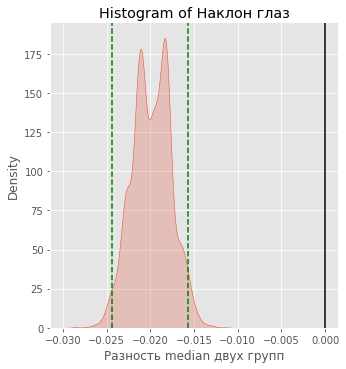

p_value:  4.44083670814436e-19 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

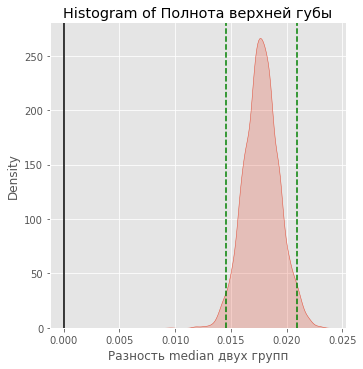

p_value:  2.2315323564576272e-29 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

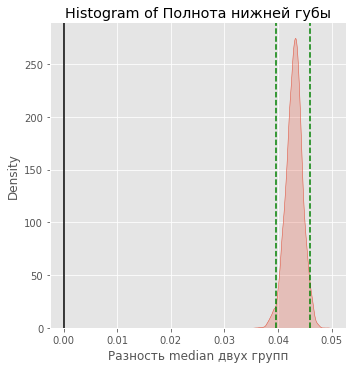

p_value:  6.507340956701096e-165 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

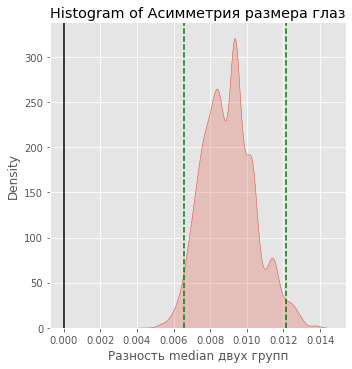

p_value:  1.5941376705654615e-10 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

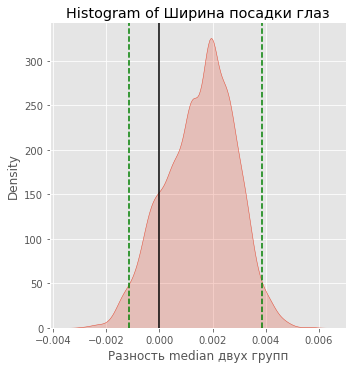

p_value:  0.24017893628281162 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

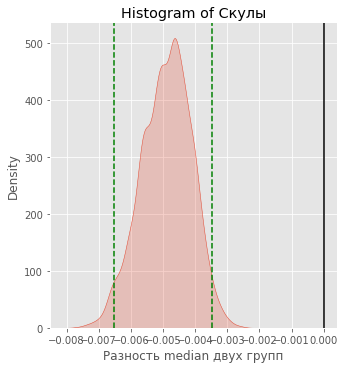

p_value:  3.275364032561761e-10 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

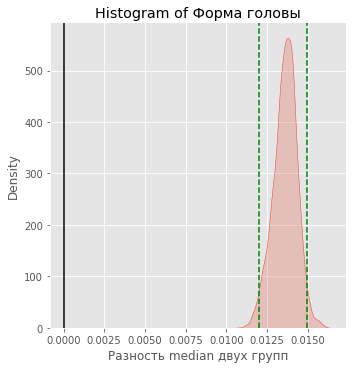

p_value:  1.785068315309744e-75 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

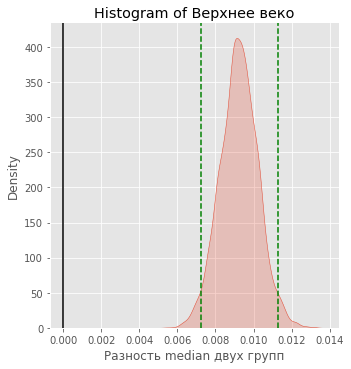

p_value:  5.176740883080172e-20 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

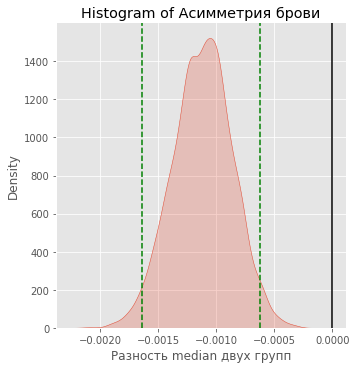

p_value:  1.2797030308388303e-05 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

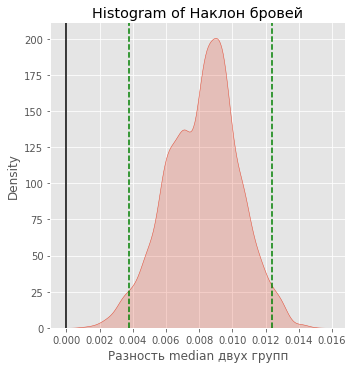

p_value:  0.00012074275753007098 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

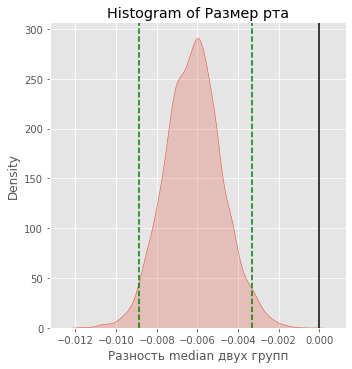

p_value:  1.1342283483091674e-05 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

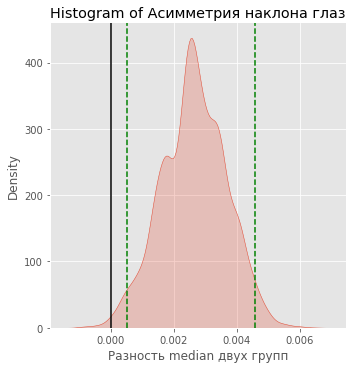

p_value:  0.010460313986228029 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

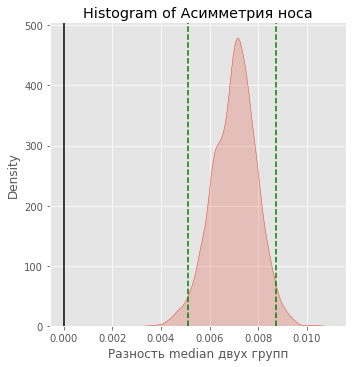

p_value:  7.971231739116099e-15 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

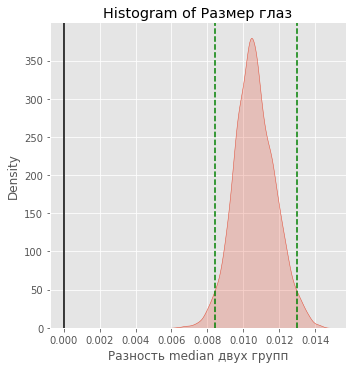

p_value:  1.2142158211609407e-20 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

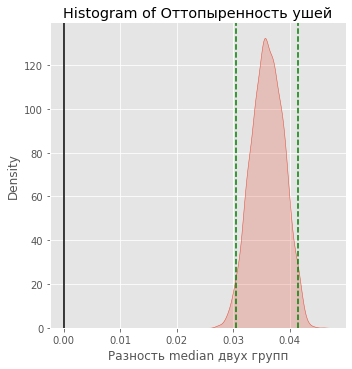

p_value:  8.301327609709137e-37 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

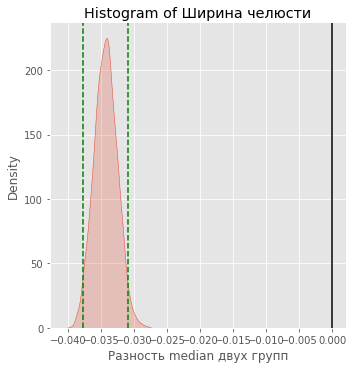

p_value:  4.561683751438277e-85 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

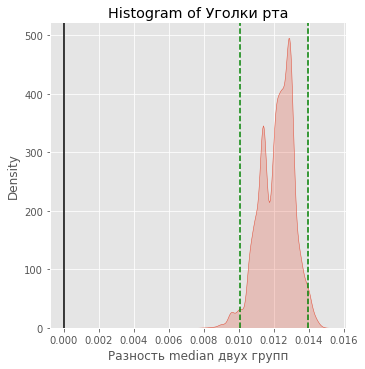

p_value:  3.612223785702305e-37 Statistical value:  True


In [4]:
bad = df[df['Категория'] == 'Мошенник']
good = df[df['Категория'] == 'Не мошенник']

l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in cols:
    res = get_bootstrap(
        bad[i], # числовые значения первой выборки
        good[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.95,
        N = n,
        concat = False,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(res['observed_difference'])
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])
    
    print("p_value: ", res['p_value'], \
          "Statistical value: ", res['p_value'] < (0.01 / 38))

In [5]:
res_boostrap = pd.DataFrame([cols, l_observed_difference, l_bot_quant, l_top_quant, l_p_value, l_result])
res_boostrap = res_boostrap.T
res_boostrap.columns = ['Feature', 'Медиана наблюдаемой разницы, %', 
                        'Нижняя граница доверительного интервала', 
                        'Верхняя граница доверительного интервала', 'p_value', 'Значимость']
res_boostrap['p_value'] = res_boostrap['p_value'].astype('float')
res_boostrap['Медиана наблюдаемой разницы, %'] = res_boostrap['Медиана наблюдаемой разницы, %']*100

res_boostrap.sort_values(by=['p_value'], ascending=False).reset_index(drop=True)
res_boostrap.to_excel('tables/bootstrap.xls')
res_boostrap.sort_values('p_value')

/tmp/ipykernel_71427/2619165962.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  res_boostrap.to_excel('tables/bootstrap.xls')


,Feature,"Медиана наблюдаемой разницы, %",Нижняя граница доверительного интервала,Верхняя граница доверительного интервала,p_value,Значимость
4,Полнота нижней губы,4.314872,0.039717,0.045994,6.507341e-165,True
17,Ширина челюсти,-3.445339,-0.037703,-0.030895,4.561684e-85,True
8,Форма головы,1.364155,0.012017,0.014955,1.785068e-75,True
18,Уголки рта,1.232494,0.010073,0.013946,3.612224e-37,True
16,Оттопыренность ушей,3.593279,0.030491,0.041459,8.301328e-37,True
3,Полнота верхней губы,1.778343,0.014592,0.02095,2.231532e-29,True
15,Размер глаз,1.043915,0.008402,0.012983,1.214216e-20,True
9,Верхнее веко,0.92944,0.007213,0.011279,5.176741e-20,True
0,Асимметрия челюсти,-0.324586,-0.003923,-0.002518,1.431849e-19,True
2,Наклон глаз,-1.931591,-0.024324,-0.015625,4.440837e-19,True


In [21]:
df.columns

Index(['loan_finished', 'folder_name', 'date_of_birth', 'loan_date',
       'loan_end_date', 'adress_index', 'adress_region', 'source', 'childs',
       'education', 'job', 'gender', 'marital_status', 'total_taken',
       'total_given', 'loan_etap_median', 'loan_etap_max', 'prolong',
       'total_profit', 'total_profit_percent', 'age', 'left_eye', 'right_eye',
       'XFrontal', 'YFrontal', 'Асимметрия челюсти', 'Высота бровей',
       'Наклон глаз', 'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       'fraud', 'Категория'],
      dtype='object')

In [22]:
df

,loan_finished,folder_name,date_of_birth,loan_date,loan_end_date,adress_index,adress_region,source,childs,education,...,Наклон бровей,Размер рта,Асимметрия наклона глаз,Асимметрия носа,Размер глаз,Оттопыренность ушей,Ширина челюсти,Уголки рта,fraud,Категория
0,1,39118-02-016_1c7ea7b8-30fd-11e5-81f6-f01fafe92f9d,1980-02-28,2018-01-11,2018-01-25,461034,Оренбургская обл,Звонок КС,3.0,средне-специальное,...,0.361596,0.841024,0.749660,0.544170,0.417998,0.345374,0.551186,0.461326,False,Не мошенник
1,1,04519-20010_dc1fb083-df28-11e7-80e7-000c293676f4,1962-09-08,2019-05-07,2019-05-21,446103,Самарская обл,Банер / Короб на офисе,0.0,среднее-техническое,...,0.137705,0.408694,0.331699,0.367598,0.571762,0.155978,0.253770,0.302405,False,Не мошенник
2,0,18-04-000018_9f0da275-01aa-11e8-80eb-000c293676f4,1977-11-03,2018-01-26,2018-02-09,461040,Оренбургская обл,Другое,0.0,среднее,...,0.539370,0.241319,0.419780,0.306869,0.366801,0.587597,0.258877,0.424033,True,Мошенник
3,1,19019-04-008_20534214-6d31-11e8-80f4-000c293676f4,1976-03-02,2019-01-22,2019-02-05,461363,Оренбургская обл,Наружная реклама,2.0,средне-специальное,...,0.152806,0.344930,0.394927,0.168948,0.248811,0.566139,0.473035,0.469741,False,Не мошенник
4,0,56318-19-021_25060137-84b6-11e7-80e6-000c293676f4,1977-05-12,2018-05-11,2018-05-25,446116,Самарская обл,Звонок КС,0.0,среднее,...,0.403270,0.160512,0.548771,0.346421,0.239004,0.134003,0.402705,0.269719,True,Мошенник
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35083,1,54918-20-015_3cb8df22-5c16-11e8-80f3-000c293676f4,1978-09-13,2018-05-20,2018-06-03,446305,Самарская обл,Банер / Короб на офисе,1.0,среднее,...,0.413527,-0.021263,0.259048,0.653560,0.703803,0.554543,0.334941,0.552744,False,Не мошенник
35084,1,04618-47-014_13b332b6-45e4-11e8-80f1-000c293676f4,1946-01-01,2018-11-24,2018-12-08,446253,Самарская обл,Банер / Короб на офисе,0.0,среднее-техническое,...,0.364004,0.772436,0.419780,0.422434,0.270699,0.333682,0.876112,0.413967,False,Не мошенник
35085,1,37018-47-006_65da8683-d9a8-11e8-80ff-000c293676f4,1960-11-28,2018-11-20,2018-12-04,460034,Оренбургская обл,Наружная реклама,0.0,среднее-техническое,...,0.442679,0.442518,0.322654,0.265440,0.500357,0.401693,-0.013355,0.737093,False,Не мошенник
35086,1,13818-09-011_b8f7cd5d-1d0d-11e8-80eb-000c293676f4,1978-02-03,2018-03-01,2018-03-08,460508,Оренбургская обл,Интернет,1.0,среднее,...,0.507281,0.639185,0.419780,0.344763,0.145234,0.679733,0.517175,0.622059,False,Не мошенник


In [23]:
save_cols = ['Асимметрия челюсти', 'Высота бровей',
       'Наклон глаз', 'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       'fraud']
df[save_cols].to_csv('export.csv')

In [24]:
df.shape

(35088, 46)